<a href="https://colab.research.google.com/github/DucNgMinh/Deep_Learning_NEU/blob/main/11204838_Nguy%E1%BB%85n_Minh_%C4%90%E1%BB%A9c_HW2_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision

import matplotlib.pyplot as plt

In [ ]:
  class XORDataset(Dataset):
    def __init__(self, size= 100):
        super().__init__()
        self.size = size
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        data = torch.randint(low= 0, high= 2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.float32)
        data += 0.1 * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [ ]:
dataset = XORDataset(size=500)

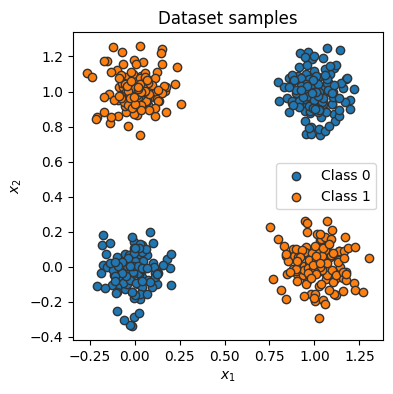

In [ ]:
data = dataset.data.numpy()
label = dataset.label.numpy()
data_0 = data[label == 0]
data_1 = data[label == 1]

plt.figure(figsize=(4,4))
plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
plt.title("Dataset samples")
plt.ylabel(r"$x_2$")
plt.xlabel(r"$x_1$")
plt.legend()


In [ ]:
data_loader = DataLoader(dataset, batch_size= 16, shuffle=True)

In [ ]:
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.linear1 = nn.Linear(2, 10)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [ ]:
model = Neural_Network()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 0.01)

num_epochs = 100
for epoch in range(num_epochs):
    for data_inputs, data_labels in data_loader:
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        loss = criterion(preds, data_labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 1.6044
Epoch [20/100], Loss: 1.4549
Epoch [30/100], Loss: 5.5472
Epoch [40/100], Loss: 1.4778
Epoch [50/100], Loss: 3.3548
Epoch [60/100], Loss: 1.6473
Epoch [70/100], Loss: 3.4198
Epoch [80/100], Loss: 0.0546
Epoch [90/100], Loss: 1.4189
Epoch [100/100], Loss: 0.0305


In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                            train=True,
                                            transform= torchvision.transforms.ToTensor() ,download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                            train=False,
                                            transform= torchvision.transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 129364193.24it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44650089.87it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35103553.03it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21747178.96it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class MNIST_Neural_Network(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MNIST_Neural_Network, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)

        return out

In [ ]:
# Hyper-parameters
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10
num_epochs = 200
batch_size = 64
learning_rate = 0.001

In [ ]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Use random_split to split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MNIST_Neural_Network(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
n_total_batches = len(train_loader)

batch_loss_list = []
epoch_loss_list = []

for epoch in range(num_epochs):
    model.train()
    current_loss = 0.
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss_list.append(loss.item())
        current_loss += loss.item()
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{n_total_batches}], Loss: {loss.item():.4f}')

    epoch_loss_list.append(current_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}] Total train Cost: {current_loss}')
    print("-" * 45)


Epoch [1/200], Batch [100/750], Loss: 2.2894
Epoch [1/200], Batch [200/750], Loss: 2.2607
Epoch [1/200], Batch [300/750], Loss: 2.2504
Epoch [1/200], Batch [400/750], Loss: 2.2147
Epoch [1/200], Batch [500/750], Loss: 2.2002
Epoch [1/200], Batch [600/750], Loss: 2.1719
Epoch [1/200], Batch [700/750], Loss: 2.1577
Epoch [1/200] Total train Cost: 1672.1589181423187
---------------------------------------------
Epoch [2/200], Batch [100/750], Loss: 2.0974
Epoch [2/200], Batch [200/750], Loss: 2.0930
Epoch [2/200], Batch [300/750], Loss: 2.0578
Epoch [2/200], Batch [400/750], Loss: 2.0316
Epoch [2/200], Batch [500/750], Loss: 2.0418
Epoch [2/200], Batch [600/750], Loss: 1.9430
Epoch [2/200], Batch [700/750], Loss: 1.9123
Epoch [2/200] Total train Cost: 1524.2840538024902
---------------------------------------------
Epoch [3/200], Batch [100/750], Loss: 1.8903
Epoch [3/200], Batch [200/750], Loss: 1.8827
Epoch [3/200], Batch [300/750], Loss: 1.8707
Epoch [3/200], Batch [400/750], Loss: 1.7

Text(0.5, 1.0, 'Epoch Loss')

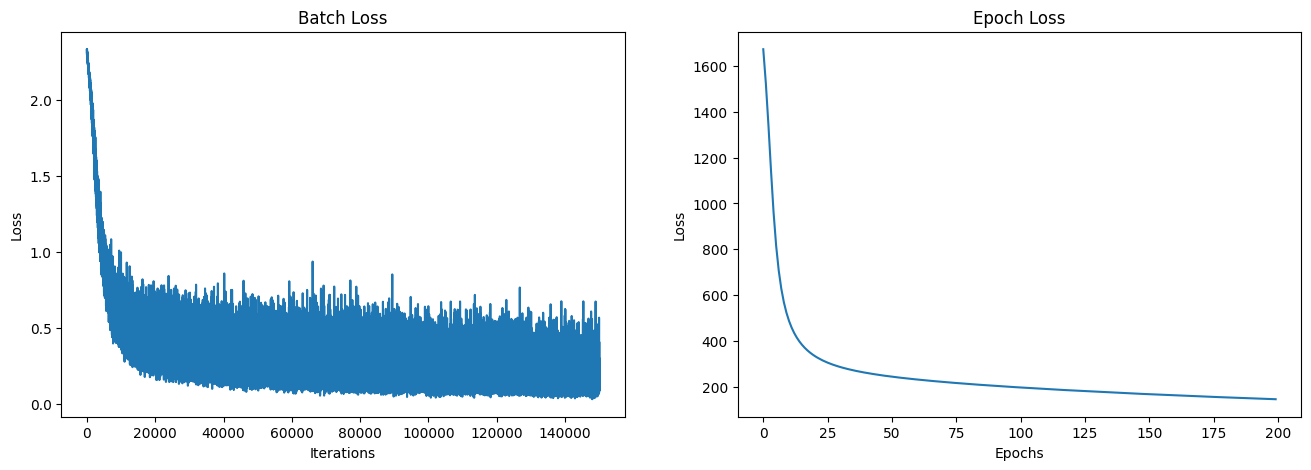

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(range(len(batch_loss_list)), (batch_loss_list), label='Batch Loss')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Loss')
ax[0].set_title('Batch Loss')

ax[1].plot(range(len(epoch_loss_list)), (epoch_loss_list), label='Epoch Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Epoch Loss')

In [ ]:
predictions = []

for i, (images, labels) in enumerate(val_loader):
  # origin shape: [100, 1, 28, 28]
  # resized: [100, 784]
  images = images.reshape(-1, 28*28).to(device)
  labels = labels.to(device)
  with torch.no_grad():
  # Forward pass
    outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)
  predictions.append(predicted)

predictions = torch.cat(predictions, dim=0).to(torch.float64)

In [ ]:
val_labels = []
for i, (images, labels) in enumerate(val_loader):
  val_labels.extend(labels.tolist())
actual_values = torch.tensor(val_labels, dtype=torch.float64).to(device)

In [ ]:
def MSE(yhat, y):
    return torch.mean((yhat - y) ** 2).item()

def RMSE(yhat, y):
    return torch.sqrt(torch.mean((yhat - y) ** 2)).item()

def MAE(yhat, y):
    return torch.mean(torch.abs(yhat - y) ** 2).item()

def MAPE(yhat, y):
    epsilon = 1e-8
    return torch.mean(torch.abs((yhat - y) / (y + epsilon))).item() * 100

In [ ]:
print(predictions)
print(actual_values)

tensor([7., 7., 6.,  ..., 3., 0., 0.], device='cuda:0', dtype=torch.float64)
tensor([7., 7., 6.,  ..., 3., 0., 0.], device='cuda:0', dtype=torch.float64)


In [ ]:
print("MSE: {:.4f}".format(MSE(predictions, actual_values)))
print("RMSE: {:.4f}".format(RMSE(predictions, actual_values)))
print("MAE: {:.4f}".format(MAE(predictions, actual_values)))
print("MAPE: {:.4f}%".format(MAPE(predictions, actual_values)))

MSE: 1.1913
RMSE: 1.0915
MAE: 1.1913
MAPE: 150833339.2498%
